In [1]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install "monai-weekly[nibabel]"
!pip install -U pytorch-lightning
!pip install torchmetrics
!pip install -U tqdm
%matplotlib inline

In [2]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a779d942-2a49-1dd5-9b4b-2a1127dfbe05)


In [3]:
import tqdm
print(tqdm.__version__)
assert tqdm.__version__ >='4.47.0', 'tqdm version >=4.47.0'

4.61.1


In [4]:
#download data
import os
if os.path.isfile('./Task09_Spleen.tar') is False:
  !wget https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar

--2021-07-15 10:15:58--  https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar
Resolving msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)... 52.92.163.234
Connecting to msd-for-monai.s3-us-west-2.amazonaws.com (msd-for-monai.s3-us-west-2.amazonaws.com)|52.92.163.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610352640 (1.5G) [application/x-tar]
Saving to: ‘Task09_Spleen.tar’

Task09_Spleen.tar   100%[===================>]   1.50G  36.5MB/s    in 44s     

2021-07-15 10:16:42 (35.2 MB/s) - ‘Task09_Spleen.tar’ saved [1610352640/1610352640]



In [5]:
import tarfile
if os.path.isdir('./Task09_Spleen') is False:
  my_tar = tarfile.open('./Task09_Spleen.tar')
  my_tar.extractall('./')
  my_tar.close()

In [6]:
from glob import glob
import os
images = sorted(glob("./Task09_Spleen/imagesTr/*.nii.gz"))
segs = sorted(glob("./Task09_Spleen/labelsTr/*.nii.gz"))
data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, segs)
        ]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
import nibabel as nib
for i in range(len(train_files)):
  img = nib.load(train_files[i]['image']).get_fdata()
  lab = nib.load(train_files[i]['label']).get_fdata()
  print(img.shape,lab.shape)
  break

(512, 512, 55) (512, 512, 55)


In [8]:
import nibabel as nib
raw_val_data=[]
for i in range(len(val_files)):
  img = nib.load(val_files[i]['image']).get_fdata()
  lab = nib.load(val_files[i]['label']).get_fdata()
  print(img.shape,lab.shape)
  raw_val_data.append((img,lab))
  

(512, 512, 33) (512, 512, 33)
(512, 512, 50) (512, 512, 50)
(512, 512, 135) (512, 512, 135)
(512, 512, 97) (512, 512, 97)
(512, 512, 101) (512, 512, 101)
(512, 512, 80) (512, 512, 80)
(512, 512, 60) (512, 512, 60)
(512, 512, 31) (512, 512, 31)
(512, 512, 41) (512, 512, 41)


In [9]:
from  monai import transforms as T
train_transforms = T.Compose(
            [
                T.LoadImaged(keys=["image", "label"]),
                T.AddChanneld(keys=["image", "label"]),
                T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest"),),
                T.Orientationd(keys=["image", "label"], axcodes="RAS"),
                T.ScaleIntensityd(keys=["image"]),
                T.CropForegroundd(keys=["image", "label"], source_key="image"),
                T.RandCropByPosNegLabeld(keys=["image", "label"],label_key="label",spatial_size=(64, 64, 64),pos=1,neg=1,
                    num_samples=8,image_key="image", image_threshold=0,),
                T.EnsureTyped(keys=["image", "label"]),
            ]
        )
val_transforms = T.Compose(
  [
      T.LoadImaged(keys=["image", "label"]),
      T.AddChanneld(keys=["image", "label"]),
      T.Spacingd(keys=["image", "label"],pixdim=(1.5, 1.5, 2.0),mode=("bilinear", "nearest"),),
      T.Orientationd(keys=["image", "label"], axcodes="RAS"),
      T.ScaleIntensityd(keys=["image"]),
      T.CropForegroundd(keys=["image", "label"], source_key="image"),
      T.EnsureTyped(keys=["image", "label"]),
  ]
)

In [10]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss
from torch.utils.data import DataLoader, Dataset
from monai.data import CacheDataset, list_data_collate,decollate_batch
from pytorch_lightning.loggers import TensorBoardLogger
from monai.networks.nets import UNet
from monai.metrics import DiceMetric

import torch.nn as nn
import torch
import torchmetrics


In [11]:
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=2,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                      norm=Norm.BATCH,
                  )

  #parameters
    self.lr=1e-4
    self.bs=16
    self.numworker=2
    self.criterion = DiceLoss(to_onehot_y=True, softmax=True)
    self.post_pred = T.Compose([T.EnsureType(), T.AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
    self.post_label = T.Compose([T.EnsureType(), T.AsDiscrete(to_onehot=True, n_classes=2)])
    self.metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    self.metric1= DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    self.best_val_dice = 0
    self.best_val_epoch = 0

  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=self.bs, shuffle=True,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    out=self(image)
    loss=self.criterion(out,segment)

    self.log('train/loss', loss, on_epoch=False,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = CacheDataset(data=val_files, transform=val_transforms,cache_rate=1.0, num_workers=self.numworker)
    loader=DataLoader(ds, batch_size=1, shuffle=False,num_workers=self.numworker, collate_fn=list_data_collate)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch["image"], batch["label"]
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    outputs = sliding_window_inference(image, roi_size, sw_batch_size, self.forward)
    loss=self.criterion(outputs,segment)
    outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
    labels = [self.post_label(i) for i in decollate_batch(segment)]
    self.metric(y_pred=outputs, y=labels)
    self.metric1(y_pred=outputs, y=labels)
    dice = self.metric1.aggregate().item()
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    self.log('val/dice', dice, on_epoch=True,prog_bar=True)
    return{"val_loss": loss, "val_number": len(outputs)}
  
  def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.metric.aggregate().item()
        self.metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}

In [12]:
model = OurModel()
logger = TensorBoardLogger("logs", name="my_logs")
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='./',
                                      filename='spleen200' )
trainer = Trainer(max_epochs=400, auto_lr_find=False, auto_scale_batch_size=False,
                  #tpu_cores=8,precision=16,
                  gpus=-1,precision=16,
                  logger=logger,
                  progress_bar_refresh_rate=30,
                  #resume_from_checkpoint='/content/drive/MyDrive/spleen200-v1.ckpt',
                  callbacks=[checkpoint_callback]
                  )

In [13]:
%%time
trainer.fit(model)

Validation sanity check: 0it [00:00, ?it/s]


Loading dataset:   0%|          | 0/32 [00:00<?, ?it/s]

current epoch: 0 current mean dice: 0.0390
best mean dice: 0.0390 at epoch: 0


Loading dataset: 100%|██████████| 32/32 [01:53<00:00,  3.55s/it]


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

current epoch: 0 current mean dice: 0.0332
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 1 current mean dice: 0.0337
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 2 current mean dice: 0.0344
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 3 current mean dice: 0.0334
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 4 current mean dice: 0.0317
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 5 current mean dice: 0.0314
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 6 current mean dice: 0.0310
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 7 current mean dice: 0.0355
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 8 current mean dice: 0.0377
best mean dice: 0.0390 at epoch: 0


Validating: 0it [00:00, ?it/s]

current epoch: 9 current mean dice: 0.0424
best mean dice: 0.0424 at epoch: 9


Validating: 0it [00:00, ?it/s]

current epoch: 10 current mean dice: 0.0467
best mean dice: 0.0467 at epoch: 10


Validating: 0it [00:00, ?it/s]

current epoch: 11 current mean dice: 0.0589
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 12 current mean dice: 0.0536
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 13 current mean dice: 0.0520
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 14 current mean dice: 0.0212
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 15 current mean dice: 0.0129
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 16 current mean dice: 0.0217
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 17 current mean dice: 0.0176
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 18 current mean dice: 0.0197
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 19 current mean dice: 0.0119
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 20 current mean dice: 0.0075
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 21 current mean dice: 0.0126
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 22 current mean dice: 0.0141
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 23 current mean dice: 0.0229
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 24 current mean dice: 0.0473
best mean dice: 0.0589 at epoch: 11


Validating: 0it [00:00, ?it/s]

current epoch: 25 current mean dice: 0.0785
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 26 current mean dice: 0.0344
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 27 current mean dice: 0.0235
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 28 current mean dice: 0.0208
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 29 current mean dice: 0.0190
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 30 current mean dice: 0.0192
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 31 current mean dice: 0.0271
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 32 current mean dice: 0.0459
best mean dice: 0.0785 at epoch: 25


Validating: 0it [00:00, ?it/s]

current epoch: 33 current mean dice: 0.0793
best mean dice: 0.0793 at epoch: 33


Validating: 0it [00:00, ?it/s]

current epoch: 34 current mean dice: 0.0876
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 35 current mean dice: 0.0622
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 36 current mean dice: 0.0518
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 37 current mean dice: 0.0410
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 38 current mean dice: 0.0606
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 39 current mean dice: 0.0558
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 40 current mean dice: 0.0592
best mean dice: 0.0876 at epoch: 34


Validating: 0it [00:00, ?it/s]

current epoch: 41 current mean dice: 0.1397
best mean dice: 0.1397 at epoch: 41


Validating: 0it [00:00, ?it/s]

current epoch: 42 current mean dice: 0.1772
best mean dice: 0.1772 at epoch: 42


Validating: 0it [00:00, ?it/s]

current epoch: 43 current mean dice: 0.1957
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 44 current mean dice: 0.1901
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 45 current mean dice: 0.0747
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 46 current mean dice: 0.0276
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 47 current mean dice: 0.0731
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 48 current mean dice: 0.1236
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 49 current mean dice: 0.1257
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 50 current mean dice: 0.1635
best mean dice: 0.1957 at epoch: 43


Validating: 0it [00:00, ?it/s]

current epoch: 51 current mean dice: 0.2107
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 52 current mean dice: 0.1665
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 53 current mean dice: 0.1422
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 54 current mean dice: 0.0731
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 55 current mean dice: 0.1056
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 56 current mean dice: 0.0748
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 57 current mean dice: 0.1218
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 58 current mean dice: 0.1866
best mean dice: 0.2107 at epoch: 51


Validating: 0it [00:00, ?it/s]

current epoch: 59 current mean dice: 0.2281
best mean dice: 0.2281 at epoch: 59


Validating: 0it [00:00, ?it/s]

current epoch: 60 current mean dice: 0.2488
best mean dice: 0.2488 at epoch: 60


Validating: 0it [00:00, ?it/s]

current epoch: 61 current mean dice: 0.2150
best mean dice: 0.2488 at epoch: 60


Validating: 0it [00:00, ?it/s]

current epoch: 62 current mean dice: 0.1158
best mean dice: 0.2488 at epoch: 60


Validating: 0it [00:00, ?it/s]

current epoch: 63 current mean dice: 0.0324
best mean dice: 0.2488 at epoch: 60


Validating: 0it [00:00, ?it/s]

current epoch: 64 current mean dice: 0.1630
best mean dice: 0.2488 at epoch: 60


Validating: 0it [00:00, ?it/s]

current epoch: 65 current mean dice: 0.3039
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 66 current mean dice: 0.0411
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 67 current mean dice: 0.2410
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 68 current mean dice: 0.1874
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 69 current mean dice: 0.1101
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 70 current mean dice: 0.0478
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 71 current mean dice: 0.1284
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 72 current mean dice: 0.1303
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 73 current mean dice: 0.0944
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 74 current mean dice: 0.0861
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 75 current mean dice: 0.0881
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 76 current mean dice: 0.0817
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 77 current mean dice: 0.0533
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 78 current mean dice: 0.0449
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 79 current mean dice: 0.0484
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 80 current mean dice: 0.0898
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 81 current mean dice: 0.1158
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 82 current mean dice: 0.1262
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 83 current mean dice: 0.1090
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 84 current mean dice: 0.0575
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 85 current mean dice: 0.1821
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 86 current mean dice: 0.1657
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 87 current mean dice: 0.1819
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 88 current mean dice: 0.2010
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 89 current mean dice: 0.2708
best mean dice: 0.3039 at epoch: 65


Validating: 0it [00:00, ?it/s]

current epoch: 90 current mean dice: 0.3571
best mean dice: 0.3571 at epoch: 90


Validating: 0it [00:00, ?it/s]

current epoch: 91 current mean dice: 0.4404
best mean dice: 0.4404 at epoch: 91


Validating: 0it [00:00, ?it/s]

current epoch: 92 current mean dice: 0.4287
best mean dice: 0.4404 at epoch: 91


Validating: 0it [00:00, ?it/s]

current epoch: 93 current mean dice: 0.4188
best mean dice: 0.4404 at epoch: 91


Validating: 0it [00:00, ?it/s]

current epoch: 94 current mean dice: 0.4997
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 95 current mean dice: 0.4417
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 96 current mean dice: 0.4009
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 97 current mean dice: 0.4211
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 98 current mean dice: 0.4631
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 99 current mean dice: 0.4568
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 100 current mean dice: 0.4484
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 101 current mean dice: 0.4234
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 102 current mean dice: 0.4150
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 103 current mean dice: 0.4523
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 104 current mean dice: 0.2751
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 105 current mean dice: 0.3570
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 106 current mean dice: 0.3155
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 107 current mean dice: 0.1911
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 108 current mean dice: 0.3889
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 109 current mean dice: 0.3440
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 110 current mean dice: 0.2409
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 111 current mean dice: 0.2760
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 112 current mean dice: 0.2073
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 113 current mean dice: 0.1953
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 114 current mean dice: 0.1530
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 115 current mean dice: 0.1216
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 116 current mean dice: 0.1431
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 117 current mean dice: 0.1905
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 118 current mean dice: 0.2462
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 119 current mean dice: 0.1579
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 120 current mean dice: 0.2111
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 121 current mean dice: 0.2762
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 122 current mean dice: 0.2849
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 123 current mean dice: 0.2690
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 124 current mean dice: 0.2800
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 125 current mean dice: 0.1877
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 126 current mean dice: 0.2457
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 127 current mean dice: 0.2825
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 128 current mean dice: 0.2136
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 129 current mean dice: 0.2432
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 130 current mean dice: 0.2564
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 131 current mean dice: 0.2737
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 132 current mean dice: 0.2850
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 133 current mean dice: 0.2839
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 134 current mean dice: 0.3507
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 135 current mean dice: 0.2636
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 136 current mean dice: 0.1985
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 137 current mean dice: 0.3080
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 138 current mean dice: 0.3169
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 139 current mean dice: 0.3392
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 140 current mean dice: 0.4655
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 141 current mean dice: 0.4159
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 142 current mean dice: 0.4138
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 143 current mean dice: 0.4466
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 144 current mean dice: 0.4172
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 145 current mean dice: 0.4452
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 146 current mean dice: 0.4384
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 147 current mean dice: 0.3848
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 148 current mean dice: 0.3614
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 149 current mean dice: 0.3758
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 150 current mean dice: 0.2613
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 151 current mean dice: 0.3654
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 152 current mean dice: 0.4946
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 153 current mean dice: 0.4337
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 154 current mean dice: 0.4950
best mean dice: 0.4997 at epoch: 94


Validating: 0it [00:00, ?it/s]

current epoch: 155 current mean dice: 0.5018
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 156 current mean dice: 0.4679
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 157 current mean dice: 0.4216
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 158 current mean dice: 0.3401
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 159 current mean dice: 0.4135
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 160 current mean dice: 0.4280
best mean dice: 0.5018 at epoch: 155


Validating: 0it [00:00, ?it/s]

current epoch: 161 current mean dice: 0.5024
best mean dice: 0.5024 at epoch: 161


Validating: 0it [00:00, ?it/s]

current epoch: 162 current mean dice: 0.4117
best mean dice: 0.5024 at epoch: 161


Validating: 0it [00:00, ?it/s]

current epoch: 163 current mean dice: 0.4483
best mean dice: 0.5024 at epoch: 161


Validating: 0it [00:00, ?it/s]

current epoch: 164 current mean dice: 0.4928
best mean dice: 0.5024 at epoch: 161


Validating: 0it [00:00, ?it/s]

current epoch: 165 current mean dice: 0.4664
best mean dice: 0.5024 at epoch: 161


Validating: 0it [00:00, ?it/s]

current epoch: 166 current mean dice: 0.5433
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 167 current mean dice: 0.4716
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 168 current mean dice: 0.4068
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 169 current mean dice: 0.4763
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 170 current mean dice: 0.4714
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 171 current mean dice: 0.3995
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 172 current mean dice: 0.3964
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 173 current mean dice: 0.4534
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 174 current mean dice: 0.4265
best mean dice: 0.5433 at epoch: 166


Validating: 0it [00:00, ?it/s]

current epoch: 175 current mean dice: 0.5651
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 176 current mean dice: 0.4629
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 177 current mean dice: 0.3373
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 178 current mean dice: 0.4114
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 179 current mean dice: 0.2831
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 180 current mean dice: 0.4289
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 181 current mean dice: 0.4151
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 182 current mean dice: 0.3204
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 183 current mean dice: 0.2942
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 184 current mean dice: 0.5561
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 185 current mean dice: 0.4372
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 186 current mean dice: 0.4595
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 187 current mean dice: 0.3583
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 188 current mean dice: 0.2911
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 189 current mean dice: 0.4545
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 190 current mean dice: 0.5099
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 191 current mean dice: 0.2898
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 192 current mean dice: 0.4185
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 193 current mean dice: 0.5168
best mean dice: 0.5651 at epoch: 175


Validating: 0it [00:00, ?it/s]

current epoch: 194 current mean dice: 0.5844
best mean dice: 0.5844 at epoch: 194


Validating: 0it [00:00, ?it/s]

current epoch: 195 current mean dice: 0.4564
best mean dice: 0.5844 at epoch: 194


Validating: 0it [00:00, ?it/s]

current epoch: 196 current mean dice: 0.5832
best mean dice: 0.5844 at epoch: 194


Validating: 0it [00:00, ?it/s]

current epoch: 197 current mean dice: 0.5598
best mean dice: 0.5844 at epoch: 194


Validating: 0it [00:00, ?it/s]

current epoch: 198 current mean dice: 0.6084
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 199 current mean dice: 0.4512
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 200 current mean dice: 0.3562
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 201 current mean dice: 0.4826
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 202 current mean dice: 0.5918
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 203 current mean dice: 0.5255
best mean dice: 0.6084 at epoch: 198


Validating: 0it [00:00, ?it/s]

current epoch: 204 current mean dice: 0.6357
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 205 current mean dice: 0.4507
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 206 current mean dice: 0.2947
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 207 current mean dice: 0.5407
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 208 current mean dice: 0.5563
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 209 current mean dice: 0.5286
best mean dice: 0.6357 at epoch: 204


Validating: 0it [00:00, ?it/s]

current epoch: 210 current mean dice: 0.6923
best mean dice: 0.6923 at epoch: 210


Validating: 0it [00:00, ?it/s]

current epoch: 211 current mean dice: 0.7228
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 212 current mean dice: 0.6645
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 213 current mean dice: 0.6615
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 214 current mean dice: 0.3608
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 215 current mean dice: 0.2919
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 216 current mean dice: 0.5721
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 217 current mean dice: 0.6388
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 218 current mean dice: 0.6533
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 219 current mean dice: 0.6119
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 220 current mean dice: 0.5754
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 221 current mean dice: 0.4883
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 222 current mean dice: 0.4497
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 223 current mean dice: 0.5220
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 224 current mean dice: 0.5346
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 225 current mean dice: 0.6000
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 226 current mean dice: 0.7162
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 227 current mean dice: 0.6083
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 228 current mean dice: 0.5619
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 229 current mean dice: 0.6586
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 230 current mean dice: 0.7105
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 231 current mean dice: 0.6023
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 232 current mean dice: 0.6258
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 233 current mean dice: 0.6911
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 234 current mean dice: 0.6450
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 235 current mean dice: 0.5821
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 236 current mean dice: 0.4667
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 237 current mean dice: 0.4478
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 238 current mean dice: 0.2674
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 239 current mean dice: 0.3510
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 240 current mean dice: 0.3273
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 241 current mean dice: 0.3167
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 242 current mean dice: 0.4090
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 243 current mean dice: 0.4095
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 244 current mean dice: 0.4394
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 245 current mean dice: 0.3398
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 246 current mean dice: 0.4540
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 247 current mean dice: 0.5198
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 248 current mean dice: 0.5621
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 249 current mean dice: 0.5153
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 250 current mean dice: 0.5885
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 251 current mean dice: 0.6173
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 252 current mean dice: 0.6515
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 253 current mean dice: 0.6453
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 254 current mean dice: 0.7039
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 255 current mean dice: 0.6163
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 256 current mean dice: 0.5541
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 257 current mean dice: 0.6429
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 258 current mean dice: 0.6886
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 259 current mean dice: 0.6693
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 260 current mean dice: 0.6693
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 261 current mean dice: 0.4296
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 262 current mean dice: 0.6199
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 263 current mean dice: 0.6525
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 264 current mean dice: 0.6463
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 265 current mean dice: 0.6268
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 266 current mean dice: 0.6984
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 267 current mean dice: 0.6798
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 268 current mean dice: 0.6606
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 269 current mean dice: 0.6871
best mean dice: 0.7228 at epoch: 211


Validating: 0it [00:00, ?it/s]

current epoch: 270 current mean dice: 0.7524
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 271 current mean dice: 0.6730
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 272 current mean dice: 0.6560
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 273 current mean dice: 0.5833
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 274 current mean dice: 0.6313
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 275 current mean dice: 0.7510
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 276 current mean dice: 0.7421
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 277 current mean dice: 0.6764
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 278 current mean dice: 0.6510
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 279 current mean dice: 0.6612
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 280 current mean dice: 0.7067
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 281 current mean dice: 0.6588
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 282 current mean dice: 0.6153
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 283 current mean dice: 0.6371
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 284 current mean dice: 0.7369
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 285 current mean dice: 0.6588
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 286 current mean dice: 0.5569
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 287 current mean dice: 0.5295
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 288 current mean dice: 0.6536
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 289 current mean dice: 0.6848
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 290 current mean dice: 0.6846
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 291 current mean dice: 0.6953
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 292 current mean dice: 0.7052
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 293 current mean dice: 0.6374
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 294 current mean dice: 0.6484
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 295 current mean dice: 0.6618
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 296 current mean dice: 0.7182
best mean dice: 0.7524 at epoch: 270


Validating: 0it [00:00, ?it/s]

current epoch: 297 current mean dice: 0.7759
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 298 current mean dice: 0.7624
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 299 current mean dice: 0.6579
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 300 current mean dice: 0.4757
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 301 current mean dice: 0.5919
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 302 current mean dice: 0.7401
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 303 current mean dice: 0.7635
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 304 current mean dice: 0.7208
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 305 current mean dice: 0.6596
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 306 current mean dice: 0.6477
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 307 current mean dice: 0.6787
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 308 current mean dice: 0.7344
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 309 current mean dice: 0.6784
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 310 current mean dice: 0.6562
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 311 current mean dice: 0.7220
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 312 current mean dice: 0.7291
best mean dice: 0.7759 at epoch: 297


Validating: 0it [00:00, ?it/s]

current epoch: 313 current mean dice: 0.7805
best mean dice: 0.7805 at epoch: 313


Validating: 0it [00:00, ?it/s]

current epoch: 314 current mean dice: 0.7840
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 315 current mean dice: 0.7688
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 316 current mean dice: 0.7758
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 317 current mean dice: 0.7377
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 318 current mean dice: 0.6716
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 319 current mean dice: 0.6108
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 320 current mean dice: 0.5477
best mean dice: 0.7840 at epoch: 314


Validating: 0it [00:00, ?it/s]

current epoch: 321 current mean dice: 0.7935
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 322 current mean dice: 0.7680
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 323 current mean dice: 0.6393
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 324 current mean dice: 0.5963
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 325 current mean dice: 0.7111
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 326 current mean dice: 0.7120
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 327 current mean dice: 0.5519
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 328 current mean dice: 0.5556
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 329 current mean dice: 0.6753
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 330 current mean dice: 0.7818
best mean dice: 0.7935 at epoch: 321


Validating: 0it [00:00, ?it/s]

current epoch: 331 current mean dice: 0.7954
best mean dice: 0.7954 at epoch: 331


Validating: 0it [00:00, ?it/s]

current epoch: 332 current mean dice: 0.8000
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 333 current mean dice: 0.7669
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 334 current mean dice: 0.7161
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 335 current mean dice: 0.7493
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 336 current mean dice: 0.7439
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 337 current mean dice: 0.7628
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 338 current mean dice: 0.6600
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 339 current mean dice: 0.5029
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 340 current mean dice: 0.4930
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 341 current mean dice: 0.6303
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 342 current mean dice: 0.3564
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 343 current mean dice: 0.4398
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 344 current mean dice: 0.7174
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 345 current mean dice: 0.7508
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 346 current mean dice: 0.6802
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 347 current mean dice: 0.5289
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 348 current mean dice: 0.4243
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 349 current mean dice: 0.4549
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 350 current mean dice: 0.4733
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 351 current mean dice: 0.4850
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 352 current mean dice: 0.6181
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 353 current mean dice: 0.7604
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 354 current mean dice: 0.7760
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 355 current mean dice: 0.7693
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 356 current mean dice: 0.7512
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 357 current mean dice: 0.6572
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 358 current mean dice: 0.5578
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 359 current mean dice: 0.5381
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 360 current mean dice: 0.7244
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 361 current mean dice: 0.7404
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 362 current mean dice: 0.5918
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 363 current mean dice: 0.5259
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 364 current mean dice: 0.5865
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 365 current mean dice: 0.7213
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 366 current mean dice: 0.7843
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 367 current mean dice: 0.7848
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 368 current mean dice: 0.7232
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 369 current mean dice: 0.5878
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 370 current mean dice: 0.5105
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 371 current mean dice: 0.6359
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 372 current mean dice: 0.7870
best mean dice: 0.8000 at epoch: 332


Validating: 0it [00:00, ?it/s]

current epoch: 373 current mean dice: 0.8018
best mean dice: 0.8018 at epoch: 373


Validating: 0it [00:00, ?it/s]

current epoch: 374 current mean dice: 0.7811
best mean dice: 0.8018 at epoch: 373


Validating: 0it [00:00, ?it/s]

current epoch: 375 current mean dice: 0.8297
best mean dice: 0.8297 at epoch: 375


Validating: 0it [00:00, ?it/s]

current epoch: 376 current mean dice: 0.8356
best mean dice: 0.8356 at epoch: 376


Validating: 0it [00:00, ?it/s]

current epoch: 377 current mean dice: 0.8436
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 378 current mean dice: 0.7572
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 379 current mean dice: 0.6379
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 380 current mean dice: 0.6181
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 381 current mean dice: 0.6815
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 382 current mean dice: 0.7757
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 383 current mean dice: 0.7970
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 384 current mean dice: 0.7292
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 385 current mean dice: 0.6531
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 386 current mean dice: 0.7748
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 387 current mean dice: 0.7603
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 388 current mean dice: 0.6655
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 389 current mean dice: 0.6197
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 390 current mean dice: 0.6840
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 391 current mean dice: 0.6720
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 392 current mean dice: 0.5762
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 393 current mean dice: 0.5766
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 394 current mean dice: 0.5957
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 395 current mean dice: 0.7306
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 396 current mean dice: 0.7301
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 397 current mean dice: 0.7631
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 398 current mean dice: 0.6626
best mean dice: 0.8436 at epoch: 377


Validating: 0it [00:00, ?it/s]

current epoch: 399 current mean dice: 0.6724
best mean dice: 0.8436 at epoch: 377
CPU times: user 44min 58s, sys: 5min 36s, total: 50min 35s
Wall time: 1h 16min 2s


In [14]:
torch.save(model.state_dict(), './spleen_state200.pt')

In [15]:
print(
    f"train completed, best_metric: {model.best_val_dice:.4f} "
    f"at epoch {model.best_val_epoch}")

train completed, best_metric: 0.8436 at epoch 377


In [16]:
#model.load_state_dict(torch.load('/content/drive/MyDrive/spleen_state600.pt'))


# inference

In [17]:
post_transforms = T.Compose([
        T.ToTensord(keys="pred"), 
        T.Activationsd(keys="pred", sigmoid=True),
        T.AsDiscreted(keys="pred", threshold_values=True),
        T.Invertd(
            keys=["pred",'label'],  # invert the `pred` data field, also support multiple fields
            transform=val_transforms,
            orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
                              # then invert `pred` based on this information. we can use same info
                              # for multiple fields, also support different orig_keys for different fields
            meta_keys=["pred_meta_dict","label_meta_dict"],  # key field to save inverted meta data, every item maps to `keys`
            orig_meta_keys="image_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
                                             # for example, may need the `affine` to invert `Spacingd` transform,
                                             # multiple fields can use the same meta data to invert
            meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
                                           # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
                                           # otherwise, no need this arg during inverting
            nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
            to_tensor=True,  # convert to PyTorch Tensor after inverting
        ),
        #SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ])

In [18]:
val_dataloader=model.val_dataloader()

Loading dataset: 100%|██████████| 9/9 [00:24<00:00,  2.71s/it]


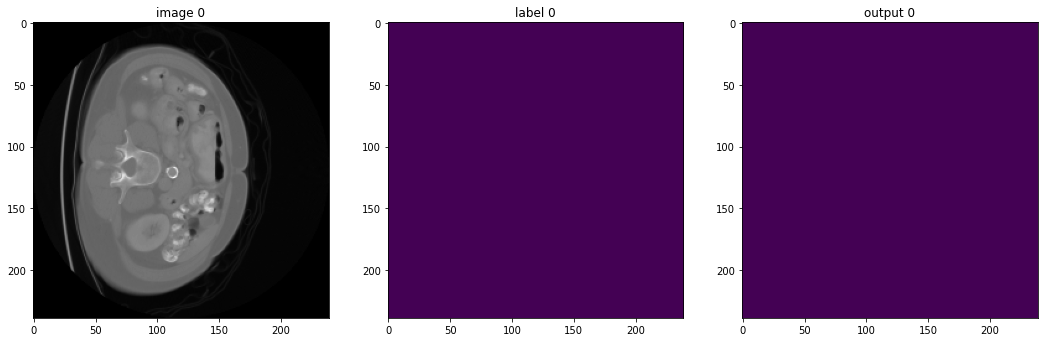

In [19]:
import matplotlib.pyplot as plt
import numpy as np
model.eval()
device = torch.device("cuda:0")
model.to(device)
ch=32
with torch.no_grad():
    for i, val_data in enumerate(val_dataloader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        output = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, ch], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, ch])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            output, dim=1).detach().cpu()[0, :, :, ch])
        plt.show()
        break
        

In [20]:
from monai.data import decollate_batch
model.eval()
post_data=[]
with torch.no_grad():
  for d in val_dataloader:
    images = d["image"].to(device)
    # define sliding window size and batch size for windows inference
    infer_outputs = sliding_window_inference(inputs=images, roi_size=(32 , 32, 32), sw_batch_size=2, predictor=model)
    infer_outputs = decollate_batch(infer_outputs)
    for (infer_output, infer_output_data) in zip(infer_outputs, decollate_batch(d)):
      infer_output_data["pred"] = infer_output
      post_data.append(post_transforms(infer_output_data))
      break
    break
    

In [21]:
out=post_data[0]
out['image'].shape,out['label'].shape,out['pred'].shape

(torch.Size([1, 239, 239, 113]),
 torch.Size([1, 512, 512, 33]),
 torch.Size([2, 512, 512, 33]))

In [22]:
raw_val=raw_val_data[0]
raw_val[0].shape,raw_val[1].shape#raw label and segment

((512, 512, 33), (512, 512, 33))

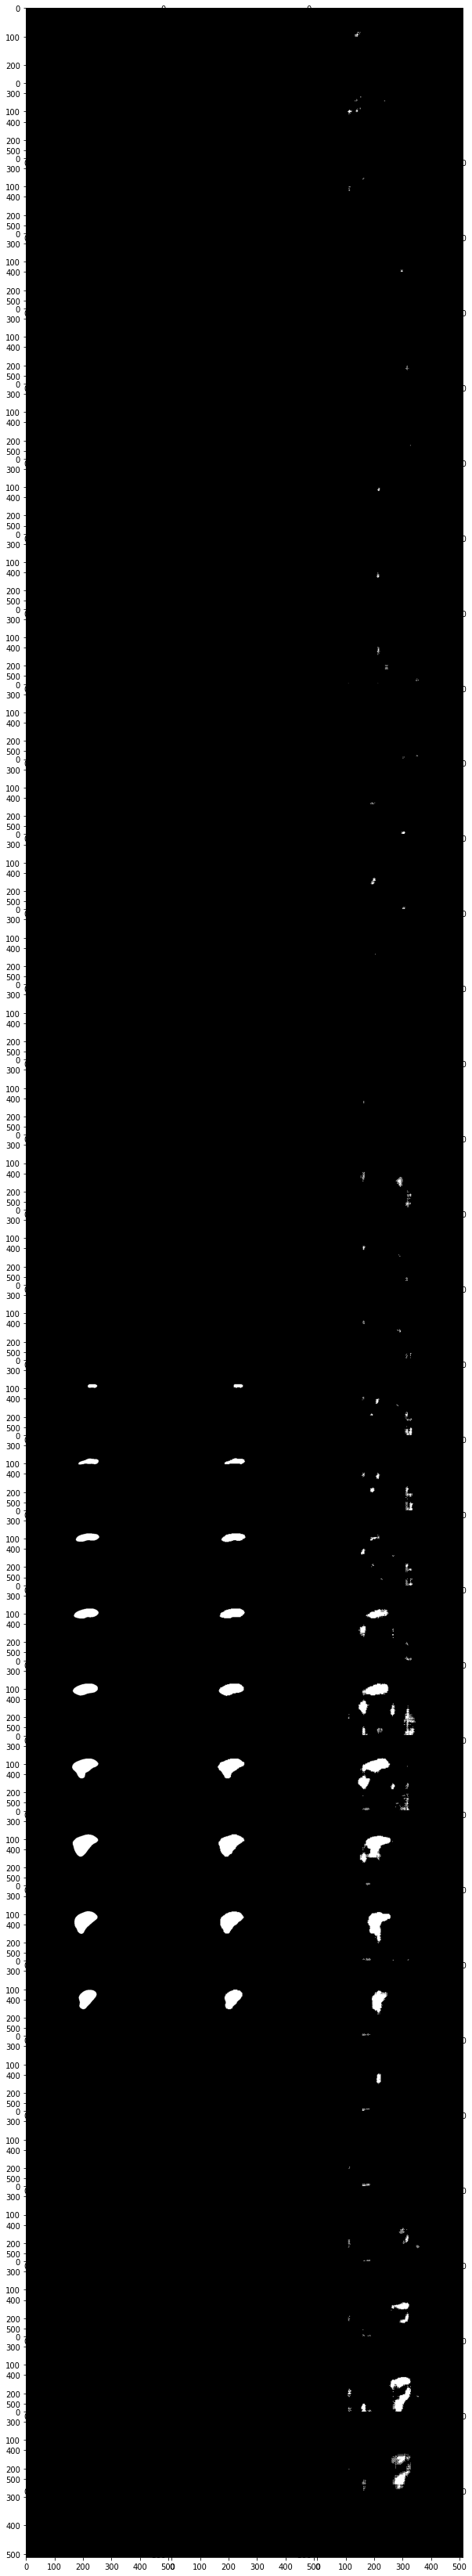

In [23]:
fig,ax=plt.subplots(33,3,figsize=(10,60))

for i in range(33):
  ax[i,0].imshow(raw_val[1][:,:,i],cmap='gray')#raw image
  ax[i,1].imshow(out['label'][0,:,:,i],cmap='gray')#inverted image
  ax[i,2].imshow(torch.argmax(out['pred'],0)[:,:,i],cmap='gray')#predicted image
plt.subplots_adjust(wspace=0, hspace=-.5)


# test

In [24]:
# post_transforms = T.Compose([
#         T.ToTensord(keys="pred"), 
#         T.Activationsd(keys="pred", sigmoid=True),
#         T.AsDiscreted(keys="pred", threshold_values=True),
#         T.Invertd(
#             keys=["pred",'label'],  # invert the `pred` data field, also support multiple fields
#             transform=val_transforms,
#             orig_keys="image",  # get the previously applied pre_transforms information on the `img` data field,
#                               # then invert `pred` based on this information. we can use same info
#                               # for multiple fields, also support different orig_keys for different fields
#             meta_keys=["pred_meta_dict","label_meta_dict"],  # key field to save inverted meta data, every item maps to `keys`
#             orig_meta_keys="image_meta_dict",  # get the meta data from `img_meta_dict` field when inverting,
#                                              # for example, may need the `affine` to invert `Spacingd` transform,
#                                              # multiple fields can use the same meta data to invert
#             meta_key_postfix="meta_dict",  # if `meta_keys=None`, use "{keys}_{meta_key_postfix}" as the meta key,
#                                            # if `orig_meta_keys=None`, use "{orig_keys}_{meta_key_postfix}",
#                                            # otherwise, no need this arg during inverting
#             nearest_interp=True,  # change to use "nearest" mode in interpolation when inverting
#             to_tensor=True,  # convert to PyTorch Tensor after inverting
#         ),
#         #SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
#     ])

In [25]:
# ds = CacheDataset(data=val_files, transform=val_transforms,cache_rate=1.0, num_workers=2)
# test_loader=DataLoader(ds, batch_size=1, shuffle=False,num_workers=2, collate_fn=list_data_collate)
# sample=next(iter(test_loader))

In [26]:
# sample['image'].shape,sample['label'].shape

In [27]:
# post_data=[]
# for d in test_loader:
#     images = d["image"].to(device)
#     # define sliding window size and batch size for windows inference
#     infer_outputs = sliding_window_inference(inputs=images, roi_size=(32 , 32, 32), sw_batch_size=2, predictor=model)
#     infer_outputs = decollate_batch(infer_outputs)
#     for (infer_output, infer_output_data) in zip(infer_outputs, decollate_batch(d)):
#       infer_output_data["pred"] = infer_output
#       post_data.append(post_transforms(infer_output_data))
#       break
#     break

In [28]:
# out=post_data[0]
# out['image'].shape,out['label'].shape,out['pred'].shape

In [29]:
# raw_val=raw_val_data[0]
# raw_val[0].shape,raw_val[1].shape#raw label and segment

In [30]:
# fig,ax=plt.subplots(33,3,figsize=(10,60))

# for i in range(33):
#   ax[i,0].imshow(raw_val[1][:,:,i],cmap='gray')#raw image
#   ax[i,1].imshow(out['label'][0,:,:,i],cmap='gray')#inverted image
#   ax[i,2].imshow(torch.argmax(out['pred'],0)[:,:,i],cmap='gray')#predicted image
# plt.subplots_adjust(wspace=0, hspace=-.5)


In [31]:
!rm -rf ./Task09_Spleen
!rm ./Task09_Spleen.tar